# Evaluating Classifiers: Cross Validation

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur with updates by Ross Beveridge

Last Update 10/26/2021

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## What does Getting Better Mean? 

We have already talked about some of these issues before, but let us revisit and be a bit more formal in our approach and definitions.  Ultimately we as machine learing practictioners are about generalization. We will find that generalization comes with a great deal of nuance - but let us start with some basics hinging upon the following question:

> Does having more training samples improve performance on unseen (test) data? 

Intuitively, that answer would appear to be an obvious 'yes'; the more data we have available, the more accurate our classifiers should become.  To demonstrate this, let's read in some data and evaluate a k-nearest neighbor classifier on a fixed test set with increasing number of training examples.  The resulting curve of accuracy as a function of number of examples is called a **learning curve**.



### Build one Test Set

Since our goal is to evaluate accuracy when adding to our training set.  Thes means we first want to use the `train_test_split` functionality of `sklearn` to create a single test set called `X_test`. Also, as we will discuss more below, stratifying our samples by the class labels in `y` is important to avoid a preponderance of one label versus another. 

Note that for this illustration we are returning to the 1797 image digits dataset. Also, the logic below is a touch unusual and is motivated by our goal of evaluating accuracy over a wide range - from small to large - of different sized training sets. 

In [25]:
X, y = load_digits(return_X_y=True)

training_sizes = [10, 20, 40, 100, 200, 400, 600, 800, 1000]
test_size_padding = 20
target_test_size = len(y) - max(training_sizes) - test_size_padding

X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size = target_test_size, 
    stratify=y, random_state=1)

print(f'We have selected {X_test.shape[0]} test images from {X.shape[0]} images total.')
print(f'The remaining {X_full_train.shape[0]} images are available for training.')


We have selected 777 test images from 1797 images total.
The remaining 1020 images are available for training.


Now for the second part of this illustration we will generate different sized training sets while leaving the test set constant.  In other words, we will create training sets out of the original `X_full_train` set which vary in size according to `training_sizes`.

In [26]:
accuracy = []
for train_n in training_sizes :
    X_train,_ , y_train,_ = train_test_split(
        X_full_train, y_full_train, train_size = train_n, stratify=y_full_train)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = np.sum((y_pred==y_test))/len(y_test)
    accuracy.append(acc)
    print(f'Training size: {X_train.shape[0]} \t yields Accuracy: {acc:5.3f}')

Training size: 10 	 yields Accuracy: 0.618
Training size: 20 	 yields Accuracy: 0.767
Training size: 40 	 yields Accuracy: 0.848
Training size: 100 	 yields Accuracy: 0.931
Training size: 200 	 yields Accuracy: 0.956
Training size: 400 	 yields Accuracy: 0.972
Training size: 600 	 yields Accuracy: 0.976
Training size: 800 	 yields Accuracy: 0.985
Training size: 1000 	 yields Accuracy: 0.988


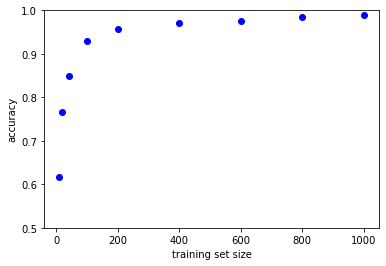

In [27]:
plt.figure(figsize=(6,4))
plt.plot(training_sizes, accuracy, 'ob')
plt.xlabel('training set size')
plt.ylabel('accuracy')
plt.ylim((0.5,1));

### Exercise

* What can you conclude from this plot?  
* Why would you want to compute a learning curve on your data?


## Making better use of our data with cross validation

The discussion above demonstrates that it is best to have as large of a training set as possible.  We also need to have a large enough test set, so that the accuracy estimates are accurate.  How do we balance these two contradictory requirements?  Cross-validation provides us a more effective way to make use of our data.  Here it is:

**Cross validation**

* Randomly partition the data into $k$ subsets ("folds").
* Set one fold aside for evaluation and train a model on the remaining $k$ folds and evaluate it on the held-out fold.
* Repeat until each fold has been used for evaluation
* Compute accuracy by averaging over the accuracy estimates generated for each fold.

Here is an illustration of 8-fold cross validation:

<img style="padding: 10px; float:left;" alt="cross-validation by MBanuelos22 CC BY-SA 4.0" src="https://upload.wikimedia.org/wikipedia/commons/c/c7/LOOCV.gif">

     width="600">

As you can see, this procedure is more expensive than dividing your data into train and test set.  When dealing with relatively small datasets, which is when you want to use this procedure, this won't be an issue.

Typically cross-validation is used with the number of folds being in the range of 5-10.  An extreme case is when the number of folds equals the number of training examples.  This special case is called *leave-one-out cross-validation*.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn import metrics

Let's use the scikit-learn breast cancer dataset to demonstrate the use of cross-validation.

In [29]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

A scikit-learn data object is container object with whose interesting attributes are: 
  * ‘data’, the data to learn, 
  * ‘target’, the classification labels, 
  * ‘target_names’, the meaning of the labels,
  * ‘feature_names’, the meaning of the features, and 
  * ‘DESCR’, the full description of the dataset.



In [30]:
X = data.data
y = data.target
print('number of examples ', len(y))
print('number of features ', len(X[0]))

print(data.target_names)
print(data.feature_names)

number of examples  569
number of features  30
['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [31]:
# Random state 23 is fun - means worse performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
classifier = KNeighborsClassifier(n_neighbors=3)
#classifier = LogisticRegression()

_ = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Let's compute the accuracy of our predictions using a 60 percent 40 percent training to test split:

In [32]:
print(f'The 60 percent 40 percent split accuracty is: {np.mean(y_pred==y_test):1.3f}')

The 60 percent 40 percent split accuracty is: 0.939


We can do the same using scikit-learn:

In [33]:
print(f'The 60 percent 40 percent split accuracty is: {metrics.accuracy_score(y_test, y_pred):1.3f}')

The 60 percent 40 percent split accuracty is: 0.939


Now let's compute accuracy using [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) instead:

[0.877 0.921 0.947 0.939 0.912]


Text(0.5, 1.0, 'K-Fold Results for 3-NN on Breast Cancer Data')

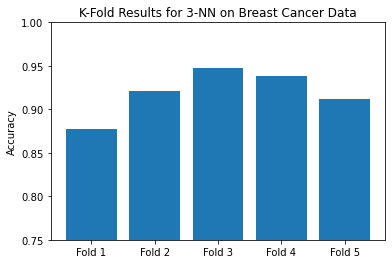

In [34]:
np.set_printoptions(precision=3)

accuracy = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
print(accuracy)
objects = ('Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, accuracy)
plt.xticks(y_pos, objects)
plt.ylim(0.75,1.0)
plt.ylabel('Accuracy')
plt.title('K-Fold Results for 3-NN on Breast Cancer Data')

This yields an array containing the accuracy values for each fold.
When reporting your results, you will typically show the mean:

In [12]:
print(f'The mean accuracty is: {np.mean(accuracy):1.3f}')

The mean accuracty is: 0.919


The arguments of `cross_val_score`:
* A classifier (anything that satisfies the scikit-learn classifier API)
* data (features/labels)
* `cv` : an integer that specifies the number of folds (can be used in more sophisticated ways as we will see below).
* `scoring`: this determines which accuracy measure is evaluated for each fold.  Here's a link to the  [list of available measures](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) in scikit-learn.

You can obtain accuracy for other metrics.  *Balanced accuracy* for example, is appropriate when the data is unbalanced (e.g. when one class contains a much larger number of examples than other classes in the data).

In [13]:
accuracy = cross_val_score(classifier, X, y, cv=5, 
                           scoring='balanced_accuracy')
print(f'The mean balanced accuracty is: {np.mean(accuracy):1.3f}')

The mean balanced accuracty is: 0.908


`cross_val_score` is somewhat limited, in that it simply returns a list of accuracy scores.  In practice, we often want to have more information about what happened during training, and also to compute multiple accuracy measures.
`cross_validate` will provide you with that information:

In [14]:
results = cross_validate(classifier, X, y, cv=5, 
                         scoring='accuracy', return_estimator=True)
print(results)

{'fit_time': array([0.001, 0.001, 0.001, 0.001, 0.001]), 'score_time': array([0.004, 0.004, 0.005, 0.005, 0.004]), 'estimator': (KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform'), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_job

The object returned by `cross_validate` is a Python dictionary as the output suggests.  To extract a specific piece of data from this object, simply access the dictionary with the appropriate key:

In [15]:
results['test_score']

array([0.877, 0.921, 0.947, 0.939, 0.912])

If you would like to know the predictions made for each training example during cross-validation use [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) instead:

In [16]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(classifier, X, y, cv=5)
print(f'The combined accuracy from 5 folds is: {metrics.accuracy_score(y, y_pred):1.3f}')

The combined accuracy from 5 folds is: 0.919


It is important to step back and look a bit more carefuly at what is being done above.  Ask yourself this deceptively simple question:

Are the predictions captured above coming from a single or many different machine learning models?

## Stratified Sampling 

Here is a real world issue - can an machine learning model learn a concept it has never seen? 

The above way of performing cross-validation doesn't always give us enough control on the process:  we usually want our machine learning experiments to be reproducible, and to be able to use the same cross-validation splits with multiple algorithms.  The scikit-learn `KFold` and `StratifiedKFold` cross-validation generators are the way to achieve that.  

`KFold` simply chooses a random subset of examples for each fold.  This strategy can lead to cross-validation folds in which the classes are not well-represented as the following toy example demonstrates:

In [17]:
from sklearn.model_selection import StratifiedKFold, KFold

X_toy = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9,10], [11, 12]])
y_toy = np.array([0, 0, 1, 1, 1, 1])
cv = KFold(n_splits=2, random_state=42, shuffle=True)
i  = 1
for train_idx, test_idx in cv.split(X_toy, y_toy):
    print(f'Split {i}')
    print(f'\t Test: {test_idx} Train: {train_idx}')
    X_train, X_test = X_toy[train_idx], X_toy[test_idx]
    y_train, y_test = y_toy[train_idx], y_toy[test_idx]
    print(f'\t Training labels are: {y_train}')
    i = i + 1

Split 1
	 Test: [0 1 5] Train: [2 3 4]
	 Training labels are: [1 1 1]
Split 2
	 Test: [2 3 4] Train: [0 1 5]
	 Training labels are: [0 0 1]


`StratifiedKFold` addresses this issue by making sure that each class is represented in each fold in proportion to its overall fraction in the data.  This is particularly important when one or more of the classes have few examples.

`StratifiedKFold` and `KFold` generate folds that can be used in conjunction with the cross-validation methods we saw above.
As an example, we will demonstrate the use of `StratifiedKFold` with `cross_val_score` on the breast cancer datast:

In [18]:
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
accuracy = cross_val_score(classifier, X, y, cv=cv, 
                           scoring='accuracy')
print(f'The stratified 5 folds mean accuracy is: {np.mean(accuracy):1.3f}')

The stratified 5 folds mean accuracy is: 0.935


For classification problems, `StratifiedKFold` is the preferred strategy.  

However, for regression problems `KFold` is the way to go.

#### Question

Why is `KFold` used in regression probelms rather than `StratifiedKFold`?

## A Deeper Dive into Visualizing Folds

To clarify the distinction between the different methods of generating cross-validation folds and their different parameters let's look at the following figures:

In [19]:
# the code originated with the example in ...
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
from matplotlib.colors import ListedColormap

np.random.seed(42)
n_folds = 4

# Generate the data
X = np.random.randn(100, 10)

# generate labels - classes 0,1,2 and 10,30,60 examples, respectively
y = np.array([0] * 10 + [1] * 30 + [2] * 60)

def plot_cv_indices(cv, X, y, ax, n_folds):
    """plot the indices of a cross-validation object."""
    line_width = 25
    mark_size = 25
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.zeros(len(X))
        indices[tt] = 1
        # Visualize the results
        fold_cmap = ListedColormap(['darkgreen','orangered'])
        ax.scatter(range(len(indices)), [ii] * len(indices),
                   c=indices, marker="_", lw=line_width, s=mark_size, cmap=fold_cmap)
   
    # Plot the data classes and groups at the end
    labs_cmap = ListedColormap(['plum','purple','fuchsia'])
    ax.scatter(range(len(X)), [ii+1] * len(X), c=y, marker='_', s=mark_size, lw=line_width,
               cmap=labs_cmap)

   # Formatting
    ax.set(ylim=[5,-1])
    yticklabels = list(range(1,n_folds+1)) + ['class']
    ax.set(yticks=np.arange(n_folds + 1), yticklabels=yticklabels)
    ax.set(xlabel='index', ylabel="CV fold")
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

Let's visualize the results of using `KFold` for fold generation:

In [20]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

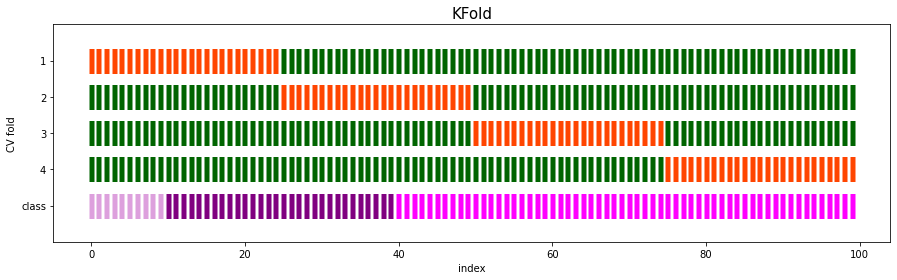

In [21]:
fig, ax = plt.subplots(figsize=(15,4))
cv = KFold(n_folds)
plot_cv_indices(cv, X, y, ax, n_folds);

As you can see, this naive way of using `KFold` can lead to highly undesirable splits into cross-validation folds.

Note the bottom row shows the class labels.  Class zero appears only in Fold 1. If an ML model is trained on Folds 2, 3 and 4 it will **never** see an instance of class zero. 

Using `StratifiedKFold` addresses this to some extent:

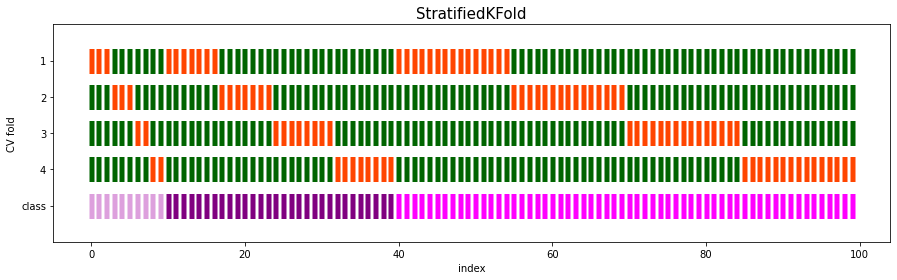

In [22]:
fig, ax = plt.subplots(figsize=(15,4))
cv = StratifiedKFold(n_folds)
plot_cv_indices(cv, X, y, ax, n_folds);

Using `StratifiedKFold` with shuffling of the examples is the preferred way of splitting the data into folds:

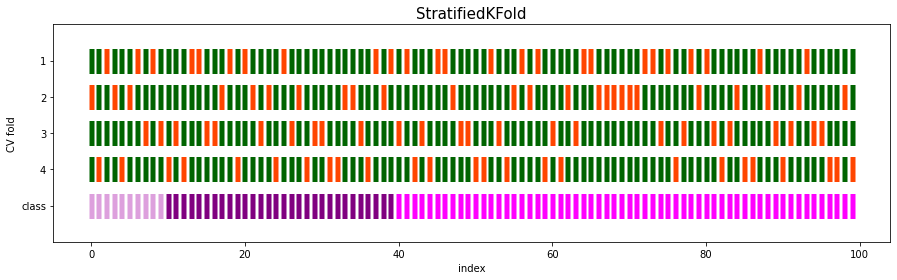

In [23]:
fig, ax = plt.subplots(figsize=(15,4))
cv = StratifiedKFold(n_folds, shuffle=True)
plot_cv_indices(cv, X, y, ax, n_folds);

### Question

Consider the task of digitizing handwritten text (aka optical character recognition, or OCR).  For each letter in the alphabet you have multiple labeled examples generated by the same writer.  How would this setup affect the way you divide your examples into training and test sets, or when performing cross-validation?


### About Leave One Out 

A limiting case for k-fold cross validation is to have as many folds are there are available data samples.  This results in what is called a leave-one-out strategy. To be clear, how this works that given $k$ total samples one builds $k$ different models trained on a set from which **only one** sample is removed from training and used for testing. 

My personal opinion is there is simply no excuse for using performing a leave-one-out evaluation if you possess a reasonably large (hundreds of samples) dataset. As you might expect - the extreme imbalance between training and test set sizes for leave-one-out creates a warped (often overly-optimistic) picture of how a machine learning algorithm generalizes. 

But let me hasten to add one important caveat. There are disciplines where sample data is very difficult and costly to acquire. For example, anything involving [FMRI](https://en.wikipedia.org/wiki/Functional_magnetic_resonance_imaging) data for people. In such a circumstance, leave-one-out may be the best option available, if trying to measure generalization given no more than perhaps $10$ to $30$ samples. 

### The Vapnik–Chervonenkis Dimension

The above commens about leave-one-out as an evaluation strategy leads to a related question.  If the sample data available for training a machine learning model is very limited, what does this imply about the choice of machine learning model. 

More particularly, how many degrees of freedom might be reasonable in a model being trained on perhaps $30$ samples? Broadly, the answer is choose a model with relatively few degrees of freedom when your training set sample size is small. Lacking a better rule of thumb, generaly there should be more samples than DOFs in your model. However, a quick caveat. This seems less true for very high DOF neural networks than - for example - polynomial basis regression.  

And, while beyone the scope of this course in detail, please look at the [Vapnik–Chervonenkis dimension](https://en.wikipedia.org/wiki/Vapnik–Chervonenkis_dimension). While the details of this theory our beyond our scope - the existence of this theory is highly significant and anyone doing machine learning should be aware of its existence. Again, the VC Dimension work provides a basis for making rigorous what for most of us are heuristic guidelines regarding the complexity of a model (number of DOF) relative to the available training data. 

### Summary and Discussion

In this notebook we discussed cross-validation as a more effective way to make use of limited amounts of data compared to the strategy of splitting data into train and test sets.  For very large datasets where training is  time consuming you might still opt for evaluation on a single test set.
